In [ ]:
import torch
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader

from utils.dataset import MovieDataset
from utils.models import MLPClassifier


torch.manual_seed(4)

# Set up

In [ ]:
from utils.loops import train_loop, eval_loop

def run_epochs(
    epochs: int,
    model, loss_fn,
    optimizer, train_loader,
    test_loader,
    use_gpu: bool = False
):
    epoch_loss = {
        'train': [],
        'test': []
    }
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        losses = train_loop(model, loss_fn,
            optimizer, train_loader,
            use_gpu
        )

        print(f"  Train loss: {sum(losses) / len(losses)}")
        eval_losses = eval_loop(model,
            loss_fn, test_loader,
            use_gpu
        )

        print(f"  Eval loss: {sum(eval_losses) / len(eval_losses)}\n")

        epoch_loss['train'].append(losses)
        epoch_loss['eval'].append(eval_losses)
    return epoch_loss

# Load Data and model

In [ ]:
dfs = [
    pd.read_csv('train_data.csv', index_col=0),
    pd.read_csv('test_data.csv', index_col=0),
]

train_data = MovieDataset(dfs[0])
test_data = MovieDataset(dfs[1])

In [58]:
batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
mlp_model = MLPClassifier()
mse_loss = nn.MSELoss()
adam_opt = torch.optim.Adam(mlp_model.parameters(), lr=1e-5)

# Training

In [ ]:
epochs = 20
global_loss = {
    'train': [],
    'eval': []
}
gpu_avail = torch.cuda.is_available()
if gpu_avail: mlp_model.cuda()

In [ ]:
loss = run_epochs(
    epochs, mlp_model,
    mse_loss, adam_opt,
    train_loader, test_loader,
    gpu_avail
)

global_loss['train'].extend(loss['train'])
global_loss['eval'].extend(loss['eval'])

Epoch 0


100%|██████████| 50/50 [00:03<00:00, 12.72it/s, Loss: 0.05791902914643288]


  Train loss: 0.05922633696347475
  Eval loss: 0.0971522256731987

Epoch 1


100%|██████████| 50/50 [00:04<00:00, 11.80it/s, Loss: 0.04161415994167328]


  Train loss: 0.051206188313663005
  Eval loss: 0.0890283862558695

Epoch 2


100%|██████████| 50/50 [00:04<00:00, 11.84it/s, Loss: 0.06737349927425385]


  Train loss: 0.051682139486074447
  Eval loss: 0.11606274745785274

Epoch 3


100%|██████████| 50/50 [00:04<00:00, 12.41it/s, Loss: 0.06589587032794952]


  Train loss: 0.05441125486046076
  Eval loss: 0.2825191164245972

Epoch 4


100%|██████████| 50/50 [00:04<00:00, 12.33it/s, Loss: 0.037248462438583374]


  Train loss: 0.05869017072021961
  Eval loss: 0.5485625897462552

Epoch 5


100%|██████████| 50/50 [00:04<00:00, 12.31it/s, Loss: 0.035410813987255096]


  Train loss: 0.053876272924244406
  Eval loss: 0.15613131798230684

Epoch 6


100%|██████████| 50/50 [00:04<00:00, 12.37it/s, Loss: 0.032966382801532745]


  Train loss: 0.052182931788265705
  Eval loss: 0.07261960237072064

Epoch 7


100%|██████████| 50/50 [00:04<00:00, 12.24it/s, Loss: 0.04435117542743683]


  Train loss: 0.047140617184340955
  Eval loss: 1.6669545540442834

Epoch 8


100%|██████████| 50/50 [00:04<00:00, 12.43it/s, Loss: 0.05692519620060921]


  Train loss: 0.05311512790620327
  Eval loss: 0.79556837448707

Epoch 9


100%|██████████| 50/50 [00:04<00:00, 12.28it/s, Loss: 0.045361824333667755]


  Train loss: 0.0493823429569602
  Eval loss: 0.19666371637812027

Epoch 10


100%|██████████| 50/50 [00:04<00:00, 12.41it/s, Loss: 0.04520949348807335]


  Train loss: 0.0486257765814662
  Eval loss: 0.31681790804633725

Epoch 11


100%|██████████| 50/50 [00:03<00:00, 12.64it/s, Loss: 0.03965311497449875]


  Train loss: 0.05314882278442383
  Eval loss: 0.32301367446780205

Epoch 12


100%|██████████| 50/50 [00:04<00:00, 12.41it/s, Loss: 0.04637414962053299]


  Train loss: 0.06760462190955878
  Eval loss: 0.3447044271116073

Epoch 13


100%|██████████| 50/50 [00:03<00:00, 12.62it/s, Loss: 0.03018706664443016]


  Train loss: 0.0557045017182827
  Eval loss: 0.06899162267263119

Epoch 14


100%|██████████| 50/50 [00:03<00:00, 12.84it/s, Loss: 0.04929801821708679]


  Train loss: 0.05780893556773663
  Eval loss: 0.12177902918595535

Epoch 15


100%|██████████| 50/50 [00:03<00:00, 12.60it/s, Loss: 0.05510270223021507]


  Train loss: 0.059563496857881544
  Eval loss: 0.13807775710637754

Epoch 16


100%|██████████| 50/50 [00:03<00:00, 12.65it/s, Loss: 0.08107000589370728]


  Train loss: 0.05631486412137747
  Eval loss: 0.11892149282189515

Epoch 17


100%|██████████| 50/50 [00:03<00:00, 12.86it/s, Loss: 0.059022340923547745]


  Train loss: 0.05304797999560833
  Eval loss: 0.06750863704543847

Epoch 18


100%|██████████| 50/50 [00:03<00:00, 12.58it/s, Loss: 0.031844764947891235]


  Train loss: 0.04970810752362013
  Eval loss: 0.12731153517961502

Epoch 19


100%|██████████| 50/50 [00:03<00:00, 12.58it/s, Loss: 0.07485102117061615]


  Train loss: 0.053132990896701815
  Eval loss: 0.2237832981806535

Epoch 20


100%|██████████| 50/50 [00:03<00:00, 12.59it/s, Loss: 0.037346094846725464]


  Train loss: 0.04983319718390703
  Eval loss: 0.14793872489379004

Epoch 21


100%|██████████| 50/50 [00:03<00:00, 12.56it/s, Loss: 0.0292494036257267]


  Train loss: 0.04808240529149771
  Eval loss: 0.19773325209434217

Epoch 22


100%|██████████| 50/50 [00:03<00:00, 12.57it/s, Loss: 0.02994457259774208]


  Train loss: 0.046219128165394065
  Eval loss: 0.15526129419987017

Epoch 23


100%|██████████| 50/50 [00:04<00:00, 12.33it/s, Loss: 0.046864066272974014]


  Train loss: 0.049704563207924365
  Eval loss: 0.1918331923393103

Epoch 24


100%|██████████| 50/50 [00:03<00:00, 12.71it/s, Loss: 0.03620938956737518]


  Train loss: 0.057710722796618937
  Eval loss: 0.19848105332885796

Epoch 25


100%|██████████| 50/50 [00:03<00:00, 12.61it/s, Loss: 0.053563810884952545]


  Train loss: 0.05712826965376735
  Eval loss: 1.1920102273042386

Epoch 26


100%|██████████| 50/50 [00:03<00:00, 12.52it/s, Loss: 0.11360074579715729]


  Train loss: 0.05651519495993853
  Eval loss: 0.06318019330501556

Epoch 27


100%|██████████| 50/50 [00:03<00:00, 12.50it/s, Loss: 0.03715922310948372]


  Train loss: 0.05821452111005783
  Eval loss: 0.11855207784817769

Epoch 28


100%|██████████| 50/50 [00:03<00:00, 12.60it/s, Loss: 0.04983263090252876]


  Train loss: 0.05319532759487629
  Eval loss: 0.05885928625670763

Epoch 29


100%|██████████| 50/50 [00:03<00:00, 12.54it/s, Loss: 0.0333014652132988]


  Train loss: 0.05482742793858051
  Eval loss: 0.1264587898667042

Epoch 30


100%|██████████| 50/50 [00:03<00:00, 12.67it/s, Loss: 0.12371525168418884]


  Train loss: 0.049695132691413166
  Eval loss: 0.1560567505657673

Epoch 31


100%|██████████| 50/50 [00:03<00:00, 12.66it/s, Loss: 0.061852872371673584]


  Train loss: 0.05209477379918098
  Eval loss: 0.27296116145757526

Epoch 32


100%|██████████| 50/50 [00:03<00:00, 12.54it/s, Loss: 0.032634809613227844]


  Train loss: 0.055302334278821946
  Eval loss: 0.2237218962265895

Epoch 33


100%|██████████| 50/50 [00:03<00:00, 12.51it/s, Loss: 0.038780421018600464]


  Train loss: 0.050404793806374075
  Eval loss: 0.3145252214028285

Epoch 34


100%|██████████| 50/50 [00:03<00:00, 12.66it/s, Loss: 0.04950909689068794]


  Train loss: 0.05254055213183165
  Eval loss: 0.2818618244849719

Epoch 35


100%|██████████| 50/50 [00:03<00:00, 12.72it/s, Loss: 0.07830491662025452]


  Train loss: 0.04783479243516922
  Eval loss: 0.056504940470823876

Epoch 36


100%|██████████| 50/50 [00:03<00:00, 12.75it/s, Loss: 0.03096720203757286]


  Train loss: 0.0518363532051444
  Eval loss: 0.27644676657823414

Epoch 37


100%|██████████| 50/50 [00:04<00:00, 12.48it/s, Loss: 0.036653026938438416]


  Train loss: 0.05069321006536484
  Eval loss: 0.4072859493585733

Epoch 38


100%|██████████| 50/50 [00:03<00:00, 12.68it/s, Loss: 0.04842793941497803]


  Train loss: 0.05460931673645973
  Eval loss: 0.15844759746239737

Epoch 39


100%|██████████| 50/50 [00:03<00:00, 12.59it/s, Loss: 0.028616830706596375]


  Train loss: 0.05161412332206965
  Eval loss: 0.18756144465162203

Epoch 40


100%|██████████| 50/50 [00:04<00:00, 12.39it/s, Loss: 0.02977430634200573]


  Train loss: 0.04869245462119579
  Eval loss: 0.542723882656831

Epoch 41


100%|██████████| 50/50 [00:03<00:00, 12.57it/s, Loss: 0.052469536662101746]


  Train loss: 0.0528347959369421
  Eval loss: 1.0467040051634495

Epoch 42


100%|██████████| 50/50 [00:03<00:00, 12.78it/s, Loss: 0.0410587303340435]


  Train loss: 0.05254897207021713
  Eval loss: 0.41807825977985674

Epoch 43


100%|██████████| 50/50 [00:04<00:00, 12.43it/s, Loss: 0.052539460361003876]


  Train loss: 0.04540610272437334
  Eval loss: 0.060487651194517426

Epoch 44


100%|██████████| 50/50 [00:03<00:00, 12.52it/s, Loss: 0.08323393017053604]


  Train loss: 0.057637127488851546
  Eval loss: 0.4198265075683594

Epoch 45


100%|██████████| 50/50 [00:04<00:00, 12.46it/s, Loss: 0.06156915798783302]


  Train loss: 0.0539953937754035
  Eval loss: 0.06745453680363986

Epoch 46


100%|██████████| 50/50 [00:03<00:00, 12.65it/s, Loss: 0.03892276808619499]


  Train loss: 0.054438514932990074
  Eval loss: 0.06215668555635672

Epoch 47


100%|██████████| 50/50 [00:03<00:00, 12.54it/s, Loss: 0.04878753051161766]


  Train loss: 0.0530010630749166
  Eval loss: 0.19425605352108294

Epoch 48


100%|██████████| 50/50 [00:03<00:00, 12.64it/s, Loss: 0.03393104672431946]


  Train loss: 0.04901263628154993
  Eval loss: 0.09199158016305703

Epoch 49


100%|██████████| 50/50 [00:03<00:00, 12.71it/s, Loss: 0.030931929126381874]


  Train loss: 0.047391015328466894
  Eval loss: 0.5183733386489061

Epoch 50


100%|██████████| 50/50 [00:03<00:00, 12.52it/s, Loss: 0.025292305275797844]


  Train loss: 0.0514209284260869
  Eval loss: 0.36309206772309083

Epoch 51


100%|██████████| 50/50 [00:04<00:00, 12.44it/s, Loss: 0.04928126931190491]


  Train loss: 0.04795862518250942
  Eval loss: 0.467053173826291

Epoch 52


100%|██████████| 50/50 [00:03<00:00, 12.50it/s, Loss: 0.040513891726732254]


  Train loss: 0.051468821074813605
  Eval loss: 2.326124656658906

Epoch 53


100%|██████████| 50/50 [00:03<00:00, 12.65it/s, Loss: 0.042820367962121964]


  Train loss: 0.04944216590374708
  Eval loss: 0.1720911659873449

Epoch 54


100%|██████████| 50/50 [00:03<00:00, 12.52it/s, Loss: 0.06273924559354782]


  Train loss: 0.056683434322476384
  Eval loss: 0.05735681120019693

Epoch 55


100%|██████████| 50/50 [00:03<00:00, 12.53it/s, Loss: 0.07259245216846466]


  Train loss: 0.053502888418734074
  Eval loss: 0.3240988575495206

Epoch 56


100%|██████████| 50/50 [00:03<00:00, 12.68it/s, Loss: 0.021833190694451332]


  Train loss: 0.051474751606583595
  Eval loss: 0.6916989523630875

Epoch 57


100%|██████████| 50/50 [00:04<00:00, 12.38it/s, Loss: 0.02823832258582115]


  Train loss: 0.0498049795627594
  Eval loss: 0.11751764153058712

Epoch 58


100%|██████████| 50/50 [00:03<00:00, 12.54it/s, Loss: 0.044482968747615814]


  Train loss: 0.05004047349095345
  Eval loss: 0.051204559894708485

Epoch 59


100%|██████████| 50/50 [00:03<00:00, 12.56it/s, Loss: 0.039322663098573685]


  Train loss: 0.04751454446464777
  Eval loss: 0.3076833073909466



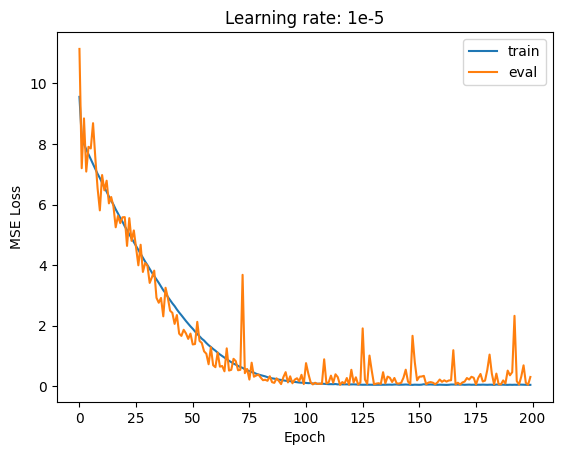

In [ ]:
import matplotlib.pyplot as plt

plt.title('Learning rate: 1e-5')
plt.plot([sum(loss) / len(loss) for loss in global_loss['train']], label='train')
plt.plot([sum(loss) / len(loss) for loss in global_loss['eval']], label='eval')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend();

In [ ]:
checkpoint = {
    'model': mlp_model.state_dict(),
    'optimizer': adam_opt.state_dict(),
    'loss': global_loss,
    'batch_size': batch_size,
    'lr': 1e-5
}

torch.save(checkpoint, '../model_checkpoints/mlp_model_cp2.tar')